# Batter Patience Model: data cleaning, model training, and testing

In [1]:
# Import appropriate libraries
import pandas, json, requests, urllib, io
import tensorflow as tf
from tensorflow import keras        
import numpy as np        
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, Input, optimizers, callbacks

In [2]:
# Gets the pitch data csv from local file
def get_total_pitch_data():

  
  pitchData = pandas.read_csv("all_pitch.csv", error_bad_lines=False)
  pitchData = pitchData.rename({"res":"result"}, axis = 1)
  del pitchData["zone"]
  pitchData["zone"] = pitchData['zones']
  pitchData["zones"] = pitchData['zones'].map(lambda x: x.rstrip('aAbB')).astype(int)
  
  return pitchData


total_pitch_data = get_total_pitch_data()

In [3]:
# Creates a map from batter ID to batter tensor 
def get_batter_tensors(df_pitch):
  batter_tensors = {}

  pitch_types = ["FF", "FT", "CU", "CH", "FC", "SL"]
  batters = df_pitch['batter_id'].unique()

  zones = df_pitch['zones'].unique()
  zones.sort()

  for batter in batters: 
    batter_tensor = [0] * len(pitch_types)

    df_batter = df_pitch.loc[df_pitch['batter_id'] == batter]
    
    for i, pitch in enumerate(pitch_types):
      batter_tensor[i] = [0] * len(zones)

      df_pitch_type = df_batter.loc[df_batter['pitch_type'] == pitch]
      for zone in zones: 
        batter_tensor[i][zone] = [0] * 2

        if df_pitch_type.shape[0] != 0: 
          df_pitch_type_zone = df_pitch_type.loc[df_pitch_type['zones'] == zone]
          num_pitch_type_in_zone = df_pitch_type_zone.shape[0]

          if num_pitch_type_in_zone != 0: 
            df_swing = df_pitch_type_zone.loc[df_pitch_type_zone['swing'] == 1]
            num_swing = df_swing.shape[0]
            proportion_swing = num_swing / num_pitch_type_in_zone

            num_hit = df_swing.loc[df_swing['result'] == 'Hit'].shape[0]
            proportion_hit = num_hit / num_pitch_type_in_zone

            batter_tensor[i][zone][0] = proportion_swing
            batter_tensor[i][zone][1] = proportion_hit
    batter_tensors[batter] = batter_tensor
  return batter_tensors

batter_tensors = get_batter_tensors(total_pitch_data)

In [4]:
# Reshapes batter tensor from (6,17,2) to (5,5,12)
def reshape_batter_tensors(batter_tensors):
    new_batter_tensors = {}
    zone_index_map = {
        0:(1,1), #(x,y)
        1:(2,1),
        2:(3,1),
        3:(1,2),
        4:(2,2),
        5:(3,2),
        6:(1,3),
        7:(2,3),
        8:(3,3),
        9:(0,0),
        10:(np.s_[1:4],0),
        11:(4,0),
        12:(0,np.s_[1:4]),
        13:(4,np.s_[1:4]),
        14:(0,4),
        15:(np.s_[1:4],4),
        16:(4,4)
    }

    for batter_key in batter_tensors.keys():
        batter = np.array(batter_tensors[batter_key])
    
        new_tensor = np.zeros((0,5,5))
        for pitch in batter:
            #print(pitch.shape)
            zone_matrix = np.zeros((2,5,5))
            
            for i, zone in enumerate(pitch):
                index = zone_index_map[i]
                #print(index)
                #print(index[0],index[1])
                #print(zone[0],zone[1])
                zone_matrix[0,index[1],index[0]]= zone[0]
                zone_matrix[1,index[1],index[0]]= zone[1]
            #print(zone_matrix.shape)
            new_tensor = np.concatenate((new_tensor,zone_matrix),axis=0)
            
        new_tensor = new_tensor.reshape((5,5,12))
        new_batter_tensors[batter_key]=new_tensor
            
        
    
    return new_batter_tensors

batter_tensors = reshape_batter_tensors(batter_tensors)


In [6]:
# Filters pitches to nonobvious outside zones
def get_reduced_df(total_df):
    return total_df[((total_df["zones"]>=9) & (total_df["zone"].str[-1]=="a"))]
new_df = get_reduced_df(total_pitch_data)

In [7]:
# Gets (5,5,6) tensor representing the pitch loc x pitch type
def get_pitch_tensor(zone, pitch_type):
    pitch_types = ["FF", "FT", "CU", "CH", "FC", "SL"]
    pitch_tensor = np.zeros((5,5,6))
    p_ind = pitch_types.index(pitch_type)
    zone_index_map = {
        0:(1,1), #(x,y)
        1:(2,1),
        2:(3,1),
        3:(1,2),
        4:(2,2),
        5:(3,2),
        6:(1,3),
        7:(2,3),
        8:(3,3),
        9:(0,0),
        10:(np.s_[1:4],0),
        11:(4,0),
        12:(0,np.s_[1:4]),
        13:(4,np.s_[1:4]),
        14:(0,4),
        15:(np.s_[1:4],4),
        16:(4,4)
    }
    pitch_tensor[zone_index_map[zone][0],zone_index_map[zone][1], p_ind] = 1
   
    return pitch_tensor
    

In [8]:
# Iterates through all pitches and creates lists of the batter, ids, outcome, strike count, ball count, pitch type
def create_input_output_tensors( batter_tensors, pitches):



  batter = []
  outcome = []
  s_count = []
  b_count = []
  ids = []
  pitch = []

  for i, row in pitches.iterrows():

    if row.batter_id in batter_tensors.keys():
       
        batter.append(batter_tensors[row.batter_id])
        ids.append((row.pitcher_id, row.batter_id, i))
        outcome.append(row.swing)
        s_count.append(row.s_count)
        b_count.append(row.b_count)
        pitch.append(get_pitch_tensor(row.zones,row.pitch_type))

  data = {
      'Batter' : batter,
      'Outcome' : outcome,
      'IDs' : ids,
      's_count': s_count,
      'b_count': b_count,
      'Pitch': pitch
      
  }

  return data

input_output_tensors = create_input_output_tensors( batter_tensors, new_df)

In [31]:
# Convert lists to np arrays 
batter_inputs = np.array(input_output_tensors['Batter'])
outcome = np.array(input_output_tensors['Outcome'])
s_count = np.array(input_output_tensors['s_count'])
b_count = np.array(input_output_tensors['b_count'])
ids = input_output_tensors['IDs']
pitch_inputs = np.array(input_output_tensors['Pitch'])

In [32]:
# Recreate tensor lists
input_output_tensors = {
    'Batter' : batter_inputs,
    'Outcome' : outcome,
    'IDs' : ids,
    's_count' : s_count,
    'b_count' : b_count,
    'Pitch' : pitch_inputs
}

In [33]:
# Create list of pitch indices for training, validation, and test
def get_train_val_test_indices(swing_df):
    train_val_test_indices = {
        'train':[],
        'validation':[],
        'test':[]
    }
    row_count = 0
    for i, row in swing_df.iterrows():
      
        
            
            if row_count< swing_df.shape[0]*.7:
                train_val_test_indices["train"].append(row_count)
            elif row_count< swing_df.shape[0]*.85:
  
                train_val_test_indices["validation"].append(row_count)
            else:
   
                train_val_test_indices["test"].append(row_count)

            row_count += 1
                
            
    
    
    return train_val_test_indices
    
train_val_test_indices = get_train_val_test_indices(new_df)

train_indices = train_val_test_indices['train']
val_indices = train_val_test_indices['validation']
test_indices = train_val_test_indices['test']

In [34]:
# Splits the data into the three sets based on the gotten indices
def get_train_val_test_sets(train_indices, val_indices, test_indices, tensors):
  b_train = []
  b_test = []
  b_val = []

  o_train = []
  o_test = []
  o_val = []

  ids_train = []
  ids_val = []
  ids_test = []
    
  sc_train = []
  sc_val = []
  sc_test = []

  bc_train = []
  bc_val = []
  bc_test = []
    
  pitch_train = []
  pitch_val = []
  pitch_test = []

  
  for i in train_indices:
    if i < len(tensors['Batter']):
        b_train.append(tensors['Batter'][i])
        o_train.append(tensors['Outcome'][i])
        ids_train.append(tensors['IDs'][i])
        sc_train.append(tensors['s_count'][i])
        bc_train.append(tensors['b_count'][i])
        pitch_train.append(tensors['Pitch'][i])
  for j in val_indices:
    if j == val_indices[0]: print("j: %s" %j)
    if j == val_indices[-1]: print("j: %s" %j)
    if j < len(tensors['Batter']):
        b_val.append(tensors['Batter'][j])
        o_val.append(tensors['Outcome'][j])
        ids_val.append(tensors['IDs'][j])
        sc_val.append(tensors['s_count'][j])
        bc_val.append(tensors['b_count'][j])
        pitch_val.append(tensors['Pitch'][j])
  for k in test_indices:
    if k == val_indices[0]: print("k: %s" %j)
    if k == val_indices[-1]: print("k: %s" %j)
    if k < len(tensors['Batter']):
        b_test.append(tensors['Batter'][k])
        o_test.append(tensors['Outcome'][k])
        ids_test.append(tensors['IDs'][k])
        sc_test.append(tensors['s_count'][k])
        bc_test.append(tensors['b_count'][k])
        pitch_test.append(tensors['Pitch'][k])
  sets = {
      'Training' : {
          'Batter' : b_train,
          'Outcome' : o_train,
          'IDs' : ids_train,
          's_count' : sc_train,
          'b_count' : bc_train,
          'Pitch' : pitch_train
      },
      'Validation' : {
          'Batter' : b_val,
          'Outcome' : o_val,
          'IDs' : ids_val,
          's_count' : sc_val,
          'b_count' : bc_val,
          'Pitch' : pitch_val
      },
      'Test' : {
          'Batter' : b_test,
          'Outcome' : o_test,
          'IDs' : ids_test,
          's_count' : sc_test,
          'b_count' : bc_test,
          'Pitch' : pitch_test
      }
  }
  return sets

input_output_tensors = get_train_val_test_sets(train_indices, val_indices, test_indices, input_output_tensors)

j: 591307
j: 718014


In [35]:
# Create lists from tensors

batter_train = input_output_tensors['Training']['Batter']
outcome_train = input_output_tensors['Training']['Outcome']
ids_train = input_output_tensors['Training']['IDs']
sc_train = input_output_tensors['Training']['s_count']
bc_train = input_output_tensors['Training']['b_count']
pitch_set_train = input_output_tensors['Training']['Pitch']


batter_val = input_output_tensors['Validation']['Batter']
outcome_val = input_output_tensors['Validation']['Outcome']
ids_val = input_output_tensors['Validation']['IDs']
sc_val = input_output_tensors['Validation']['s_count']
bc_val = input_output_tensors['Validation']['b_count']
pitch_set_val = input_output_tensors['Validation']['Pitch']


batter_test = input_output_tensors['Test']['Batter']
outcome_test = input_output_tensors['Test']['Outcome']
ids_test = input_output_tensors['Test']['IDs']
sc_test = input_output_tensors['Test']['s_count']
bc_test = input_output_tensors['Test']['b_count']
pitch_set_test = input_output_tensors['Test']['Pitch']

In [36]:
# Shuffle order of training data each time before training the model 
def randomize_order(b_tens, out_tens, ids, sc_tens, bc_tens, pitch_tens):
  together = list(zip(list(b_tens), list(out_tens), list(ids), list(sc_tens), list(bc_tens), list(pitch_tens)))
  import random
  random.shuffle(together)
  b_tens, out_tens, ids, sc_tens, bc_tens, pitch_tens = zip(*together)
  return list(b_tens), list(out_tens), list(ids), list(sc_tens), list(bc_tens), list(pitch_tens)

batter_train, outcome_train, ids_train, sc_train, bc_train, pitch_set_train = randomize_order(batter_train, outcome_train, ids_train, sc_train, bc_train, pitch_set_train)


In [37]:
# Convert lists to np arrays

batter_train, outcome_train, sc_train, bc_train, pitch_set_train = np.array(batter_train), np.array(outcome_train), np.array(sc_train), np.array(bc_train), np.array(pitch_set_train)

batter_val, outcome_val, sc_val, bc_val, pitch_set_val = np.array(batter_val), np.array(outcome_val), np.array(sc_val), np.array(bc_val), np.array(pitch_set_val)

batter_test, outcome_test, sc_test, bc_test, pitch_set_test = np.array(batter_test), np.array(outcome_test), np.array(sc_test), np.array(bc_test), np.array(pitch_set_test)

In [18]:
## DEFINE THE MODEL


 
#Batter layers
b_input = Input(shape=(5, 5, 12), dtype='float32', name='batter')
b_conv_1 = layers.Conv2D(32, (4, 4), activation='relu', padding='same', name='b_conv_1')(b_input)
b_conv_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='b_conv_2')(b_conv_1)
b_conv_3 = layers.Conv2D(32, (2, 2), activation='relu', padding='same', name='b_conv_3')(b_conv_2)
b_maxpool_1 = layers.MaxPooling2D((2,2), padding='same', name='b_maxpool_1')(b_conv_1)
b_conv_4 = layers.Conv2D(64, (2,3), activation='relu', padding='same', name='b_conv_4')(b_maxpool_1)
b_maxpool_2 = layers.MaxPooling2D((2,2), padding='same', name='b_maxpool_2')(b_conv_4)
b_conv_5 = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='b_conv_5')(b_maxpool_2)
b_maxpool_3 = layers.MaxPooling2D((2,2), padding='same', name='b_maxpool_3')(b_conv_5)
b_conv_6 = layers.Conv2D(64, (2,3), activation='relu', padding='same', name='b_conv_6')(b_maxpool_3)
b_maxpool_4 = layers.MaxPooling2D((2,2), padding='same', name='b_maxpool_4')(b_conv_6)
b_conv_7 = layers.Conv2D(64, (2,2), activation='relu', padding='same', name='b_conv_7')(b_maxpool_4)
b_maxpool_5 = layers.MaxPooling2D((2,2), padding='same', name='b_maxpool_5')(b_conv_7)
flat_batter = layers.Flatten(name='flatten_batter')(b_maxpool_5)

#Strike Count Layer
strike_count = Input(shape=(1,), dtype='float32', name = "strike_count")
#Ball Count Layer
ball_count = Input(shape=(1,), dtype='float32', name = "ball_count")

#Pitch Count Layer
pitch_input = Input(shape=(5,5,6), dtype='float32', name = 'pitch_input')
pitch_conv_1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='pitch_conv_1')(pitch_input)
pitch_maxpool_1 = layers.MaxPooling2D((2,2), padding='same', name='pitch_maxpool_1')(pitch_conv_1)
flat_pitch = layers.Flatten(name = "flatten_pitch")(pitch_maxpool_1)
#Concatenate layer
concatenated = layers.concatenate([flat_batter, strike_count, ball_count, flat_pitch], name='concat')
dense_1 = layers.Dense(128, activation='sigmoid')(concatenated)
dense_2 = layers.Dense(64, activation='sigmoid')(dense_1)


 
#Sigmoid function
output = layers.Dense(1, activation='sigmoid')(dense_2)
 
network = models.Model([b_input, strike_count, ball_count, pitch_input], output, name='Pred_Swing')
network.summary()

Model: "Pred_Swing"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batter (InputLayer)             [(None, 5, 5, 12)]   0                                            
__________________________________________________________________________________________________
b_conv_1 (Conv2D)               (None, 5, 5, 32)     6176        batter[0][0]                     
__________________________________________________________________________________________________
b_maxpool_1 (MaxPooling2D)      (None, 3, 3, 32)     0           b_conv_1[0][0]                   
__________________________________________________________________________________________________
b_conv_4 (Conv2D)               (None, 3, 3, 64)     12352       b_maxpool_1[0][0]                
_________________________________________________________________________________________

In [19]:
# Compile and train the network 
opt = optimizers.Adam(learning_rate=0.001)

network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = network.fit([ batter_train, sc_train, bc_train, pitch_set_train], outcome_train, epochs=50, batch_size=512, validation_data=([batter_val, sc_val, bc_val, pitch_set_val], outcome_val))

Epoch 1/50
1155/1155 [==============================] - 15s 12ms/step - loss: 0.6125 - accuracy: 0.6642 - val_loss: 0.6037 - val_accuracy: 0.6725
Epoch 2/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.6063 - accuracy: 0.6709 - val_loss: 0.6037 - val_accuracy: 0.6738
Epoch 3/50
1155/1155 [==============================] - 13s 11ms/step - loss: 0.6049 - accuracy: 0.6719 - val_loss: 0.6022 - val_accuracy: 0.6735
Epoch 4/50
1155/1155 [==============================] - 12s 10ms/step - loss: 0.6042 - accuracy: 0.6722 - val_loss: 0.6013 - val_accuracy: 0.6736
Epoch 5/50
1155/1155 [==============================] - 12s 10ms/step - loss: 0.6032 - accuracy: 0.6729 - val_loss: 0.6007 - val_accuracy: 0.6745
Epoch 6/50
1155/1155 [==============================] - 11s 9ms/step - loss: 0.6025 - accuracy: 0.6739 - val_loss: 0.6008 - val_accuracy: 0.6749
Epoch 7/50
1155/1155 [==============================] - 12s 10ms/step - loss: 0.6019 - accuracy: 0.6742 - val_loss: 0.5992 - 

In [20]:
# Save the trained network
network.save("take_2015-2018.h5")

In [39]:
# Test the network (loaded from model) and save the results
network_test = keras.models.load_model("take_2015-2018.h5")


pred_results = network_test.predict([batter_test,sc_test,bc_test,pitch_set_test])

    
take_dict={
    "batter_test":batter_test.tolist(),
    "ids_test":ids_test,
    "outcome_test":outcome_test.tolist(),
    "sc_test":sc_test.tolist(),
    "bc_test":bc_test.tolist(),
    "pitch_set_test":pitch_set_test.tolist(),
    "pred_test":pred_results.tolist()
}
    
with open("take_test_predictions.json", "w") as outfile: 
    json.dump(take_dict, outfile)
print("SAVED")

SAVED


In [44]:
# Import plotting libraries and set defaults for Latex

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pdf")
matplotlib.rcParams.update({
    'font.family': 'serif',
})

In [40]:
# Open test results and aggregate between batter skill

with open("take_test_predictions.json") as infile:
    test_set = json.load(infile)
    
with open("thirds.json") as infile:
    thirds = json.load(infile)
    
batter_test=np.array(test_set["batter_test"])
ids_test=np.array(test_set["ids_test"])
outcome_test=np.array(test_set["outcome_test"])
sc_test=np.array(test_set["sc_test"])
bc_test=np.array(test_set["bc_test"])
pitch_set_test=np.array(test_set["pitch_set_test"])
pred_test=np.array(test_set["pred_test"])

grouping_values = {}
grouping_values[0] = {"emp":[],"pred":[]}
grouping_values[1] = {"emp":[],"pred":[]}
grouping_values[2] = {"emp":[],"pred":[]}

b_not_in = 0
b_in = 0

for i in range(len(batter_test)):
    b_id = str(ids_test[i][1])
    if b_id in thirds["batters"].keys():
        b_group = thirds["batters"][b_id]
        b_in +=1
        s_count = sc_test[i]
        b_count = bc_test[i]


        grouping_values[b_group]["emp"].append(outcome_test[i])
        grouping_values[b_group]["pred"].append(pred_test[i])
    else:
        b_not_in += 1

  
grouping_averages = {}
grouping_averages[0] = {"emp":[],"pred":[]}
grouping_averages[1] = {"emp":[],"pred":[]}
grouping_averages[2] = {"emp":[],"pred":[]}

for group in grouping_values.keys():
    emp_vals = np.array(grouping_values[group]["emp"])
    pred_vals = np.array(grouping_values[group]["pred"])
    grouping_averages[group]["emp"]=np.mean(emp_vals)
    grouping_averages[group]["pred"]=np.mean(pred_vals)


563
126145


<class 'numpy.float64'>
0.008825067457933274
<class 'numpy.float64'>
0.004161193346578301
<class 'numpy.float64'>
0.002765461334386768
[0.010461865144924197, 0.005106784498049474, 0.00333204627082907]
[0.008825067457933274, 0.004161193346578301, 0.002765461334386768]


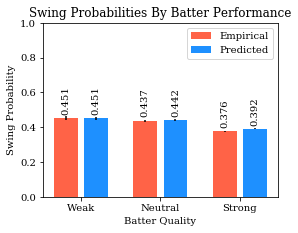

In [53]:
# Plot results aggregated between batter skill

empirical = grouping_values
labels = [0,1,2]
printed_labels = ["Weak", "Neutral", "Strong"]
emp_means = []
val_means = []
emp_yerr = []
val_yerr = []

for label in labels:
    emp_at_count = np.array(empirical[label]["emp"])
    emp_mean = np.mean(emp_at_count)
    emp_std = np.std(emp_at_count)
    emp_len = emp_at_count.shape[0]
    emp_err = (1.96*emp_std/np.sqrt(emp_len))
    print(type(emp_err))
    emp_yerr.append(emp_err)
    emp_means.append(emp_mean)

    value_iter_at_count = np.array(empirical[label]["pred"])
    val_mean = np.mean(value_iter_at_count)
    val_std = np.std(value_iter_at_count)
    val_len = value_iter_at_count.shape[0]
    val_err = 2*(1.96*val_std/np.sqrt(val_len))
    print(val_err)
    val_yerr.append(val_err)
    val_means.append(val_mean)

print(emp_yerr)
print(val_yerr)
emp_yerr = emp_yerr
data = np.arange(len(labels))  
width = 0.3
dist = .08

fig, ax = plt.subplots()
fig.set_size_inches(w=4.2, h=3.2)
rects1 = ax.bar(data - width/2 - dist/2, emp_means, width, yerr= emp_yerr, label='Empirical', color = "tomato")
rects2 = ax.bar(data + width/2 + dist/2, val_means, width, yerr= val_yerr, label='Predicted', color = "dodgerblue")


def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % float(height), rotation=90,
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

ax.set_ylim([0,1])
ax.set_ylabel('Swing Probability') 
ax.set_xlabel('Batter Quality')
ax.set_title("Swing Probabilities By Batter Performance")
ax.set_xticks(data)
ax.set_xticklabels(printed_labels)
ax.legend()
plt.show()
plt.savefig('take_batter_quality.pdf',dpi=120)

In [42]:
# Open test results and aggregate between counts

with open("take_test_predictions.json") as infile:
    test_set = json.load(infile)
batter_test=np.array(test_set["batter_test"])
ids_test=np.array(test_set["ids_test"])
outcome_test=np.array(test_set["outcome_test"])
sc_test=np.array(test_set["sc_test"])
bc_test=np.array(test_set["bc_test"])
pitch_set_test=np.array(test_set["pitch_set_test"])
pred_test=np.array(test_set["pred_test"])

count_probs={}

for i in range(len(batter_test)):
    b_id = ids_test[i][1]
    s_count = sc_test[i]
    b_count = bc_test[i]
    count = str(int(b_count)) + str(int(s_count))
    if count not in count_probs.keys():
        count_probs[count]={"emp":[],"pred":[]}
    count_probs[count]["emp"].append(outcome_test[i])
    count_probs[count]["pred"].append(pred_test[i])
    


  
del(count_probs["42"])


<class 'numpy.float64'>
0.002685176438631843
<class 'numpy.float64'>
0.0046915125245361846
<class 'numpy.float64'>
0.0066562729775496285
<class 'numpy.float64'>
0.005147261956398676
<class 'numpy.float64'>
0.0052650857311430915
<class 'numpy.float64'>
0.0052975669144396335
<class 'numpy.float64'>
0.008395401799165727
<class 'numpy.float64'>
0.007432502489102828
<class 'numpy.float64'>
0.005452071000137143
<class 'numpy.float64'>
0.005879932431614828
<class 'numpy.float64'>
0.011429349789747828
<class 'numpy.float64'>
0.0068125732551575545
[0.004593340534075057, 0.007188558738750439, 0.010244228462080363, 0.008173501556635513, 0.008329271055676827, 0.008381605528615593, 0.014613393766466571, 0.012102851731712404, 0.009154591509374529, 0.016359143983811948, 0.019924111129616395, 0.012792853740646315]
[0.002685176438631843, 0.0046915125245361846, 0.0066562729775496285, 0.005147261956398676, 0.0052650857311430915, 0.0052975669144396335, 0.008395401799165727, 0.007432502489102828, 0.0054520

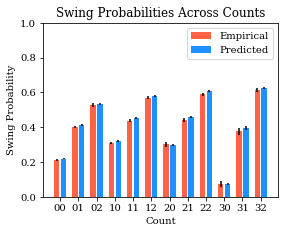

In [52]:
# Plot results aggregated between counts

empirical = count_probs
labels = ["00","01","02","10","11","12","20","21","22","30","31","32"]
emp_means = []
val_means = []
emp_yerr = []
val_yerr = []

for label in labels:
    emp_at_count = np.array(empirical[label]["emp"])
    emp_mean = np.mean(emp_at_count)
    emp_std = np.std(emp_at_count)
    emp_len = emp_at_count.shape[0]
    emp_err = (1.96*emp_std/np.sqrt(emp_len))
    emp_yerr.append(emp_err)
    emp_means.append(emp_mean)

    value_iter_at_count = np.array(empirical[label]["pred"])[:,0]
    val_mean = np.mean(value_iter_at_count)
    val_std = np.std(value_iter_at_count)
    val_len = value_iter_at_count.shape[0]
    val_err = 2*(1.96*val_std/np.sqrt(val_len))
    val_yerr.append(val_err)
    val_means.append(val_mean)


emp_yerr = emp_yerr
data = np.arange(len(labels))  
width = 0.3
dist = .08

fig, ax = plt.subplots()
fig.set_size_inches(w=4.2, h=3.2)
ax.bar(data - width/2 - dist/2, emp_means, width, yerr= emp_yerr, label='Empirical', color = "tomato")
ax.bar(data + width/2 + dist/2, val_means, width, yerr= val_yerr, label='Predicted', color = "dodgerblue")



ax.set_ylim([0,1])
ax.set_ylabel('Swing Probability') 
ax.set_xlabel('Count')
ax.set_title("Swing Probabilities Across Counts")
ax.set_xticks(data)
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('take_counts.pdf',dpi=120)

In [42]:
# Print naive (predicts "take") and model accuracy
print("Pr(swing): %s"%np.mean(outcome_test))
corrects = []

for i in range(len(outcome_test)):
    emp = outcome_test[i]
    pred_raw = pred_test[i]
    if pred_raw > .5:
        pred = 1
    else:
        pred = 0
    if emp == pred:
        corrects.append(1)
    else:
        corrects.append(0)
corrects = np.array(corrects)
print("Accuracy: %s"%np.mean(corrects))

0.39922498974019005
0.6840688827856173


In [26]:
#pr(take == outcome)

1-0.39922498974019005

0.60077501025981

In [40]:
# Open test results and aggregate between counts, pitch types, and zones

with open("take_test_predictions.json") as infile:
    test_set = json.load(infile)
batter_test=np.array(test_set["batter_test"])
ids_test=np.array(test_set["ids_test"])
outcome_test=np.array(test_set["outcome_test"])
sc_test=np.array(test_set["sc_test"])
bc_test=np.array(test_set["bc_test"])
pitch_set_test=np.array(test_set["pitch_set_test"])
pred_test=np.array(test_set["pred_test"])

results = {}

for i in range(len(batter_test)):
    if i % 10000 == 0: print(i)
    batter = batter_test[i]
    batter_id = ids_test[i][1]
    sc = sc_test[i]
    bc = bc_test[i]
    pitch_tensor = pitch_set_test[i]
    row = new_df.loc[ids_test[i][2]]
    pitch_type = row.pitch_type
    zone = row.zones
    
    count = str(int(bc))+str(int(sc))
    
    swing = outcome_test[i]
    pred_swing = pred_test[i]
   
    if count not in results.keys():
        results[count] = {}
    if pitch_type not in results[count].keys():
        results[count][pitch_type] = {}
    if zone not in results[count][pitch_type].keys():
        results[count][pitch_type][zone] = {"emp":[],"pred":[]}
    
    results[count][pitch_type][zone]["emp"].append(swing)
    results[count][pitch_type][zone]["pred"].append(pred_swing)
    
    


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000


In [43]:
for count in results.keys():
    for pitch_type in results[count].keys():
        for zone in results[count][pitch_type].keys():
            print("Count: %s, Zone: %s, Pitch Type: %s"%(count,zone,pitch_type))
            print("%s instances"%(len(results[count][pitch_type][zone]["emp"])))
            print("Emperical Swing Percentage: %s" %(np.mean(results[count][pitch_type][zone]["emp"])))
            print("Predicted Swing Percentage: %s" %(np.mean(results[count][pitch_type][zone]["pred"])))


Count: 10, Zone: 13, Pitch Type: FF
1366 instances
Emperical Swing Percentage: 0.22913616398243045
Predicted Swing Percentage: 0.21733092594111822
Count: 10, Zone: 12, Pitch Type: FF
1417 instances
Emperical Swing Percentage: 0.2173606210303458
Predicted Swing Percentage: 0.2536828661982914
Count: 10, Zone: 15, Pitch Type: FF
374 instances
Emperical Swing Percentage: 0.20855614973262032
Predicted Swing Percentage: 0.2359670992681687
Count: 10, Zone: 10, Pitch Type: FF
453 instances
Emperical Swing Percentage: 0.24503311258278146
Predicted Swing Percentage: 0.26993665474140094
Count: 10, Zone: 9, Pitch Type: FF
48 instances
Emperical Swing Percentage: 0.14583333333333334
Predicted Swing Percentage: 0.13153931188086668
Count: 10, Zone: 12, Pitch Type: FT
1238 instances
Emperical Swing Percentage: 0.3651050080775444
Predicted Swing Percentage: 0.4054870520009748
Count: 10, Zone: 15, Pitch Type: FT
673 instances
Emperical Swing Percentage: 0.3298662704309064
Predicted Swing Percentage: 0.3